## 1. Dataset Visualization
### 1) Goal
Before constructing the classification model, let's visualize the dataset and define the task in the first place. <br>
<b>Step 1:</b> Load and check the labels and training data.

In [1]:
import numpy as np
import pandas as pd
import sys

root_path = f'{sys.path[0]}/'
labels = pd.read_csv(root_path+'labels.csv')
data = pd.read_csv(root_path+'train.csv')

In [4]:
labels.head()

,attribute_id,attribute_name
0,0,country::afghanistan
1,1,country::alamania
2,2,country::algeria
3,3,country::arabia
4,4,country::armenia


In [5]:
data.head()

,id,attribute_ids
0,000040d66f14ced4cdd18cd95d91800f,448 2429 782
1,0000ef13e37ef70412166725ec034a8a,2997 3231 2730 3294 3099 2017 784
2,0001eeb4a06e8daa7c6951bcd124c3c7,2436 1715 23
3,000226398d224de78b191e6db45fd94e,2997 3433 448 782
4,00029c3b0171158d63b1bbf803a7d750,3465 3322 3170 1553 781


<b>Step 2:</b> Split the attribute names into catagories and types.

In [6]:
def _split_attr_names(attr_name_str):
    return [item.strip() for item in attr_name_str.split('::')] 

def _split_labels(labels_dataframe):
    split_labels_dict = dict(attribute_id=[], attr_tier1=[], attr_tier2=[])
    for i in range(labels_dataframe.shape[0]):
        tem = _split_attr_names(labels['attribute_name'][i])
        split_labels_dict['attribute_id'].append(labels['attribute_id'][i])
        split_labels_dict['attr_tier1'].append(tem[0])
        split_labels_dict['attr_tier2'].append(tem[1]) 
    split_labels = pd.DataFrame(split_labels_dict, 
                                columns=['attribute_id', 'attr_tier1', 'attr_tier2'])
    return split_labels

In [7]:
split_labels = _split_labels(labels)
split_labels.head()

,attribute_id,attr_tier1,attr_tier2
0,0,country,afghanistan
1,1,country,alamania
2,2,country,algeria
3,3,country,arabia
4,4,country,armenia


In [8]:
catagories = sorted(list(set(list(split_labels['attr_tier1']))))
print(len(catagories))

5


In [9]:
print('There are in total 5 catagories: %s, %s, %s, %s, %s.'
     %(catagories[0],
       catagories[1],
       catagories[2],
       catagories[3],
       catagories[4]))

There are in total 5 catagories: country, culture, dimension, medium, tags.


<b>Step 3:</b> Define the types of classification tasks.

In [10]:
def label_indexer_coarse(labels_dataframe):
    split_labels_dict = dict(attribute_id=[], attr_tier1=[], attr_tier2=[])
    for i in range(labels_dataframe.shape[0]):
        tem = [item.strip() for item in labels_dataframe['attribute_name'][i].split('::')] 
        split_labels_dict['attribute_id'].append(labels_dataframe['attribute_id'][i])
        split_labels_dict['attr_tier1'].append(tem[0])
        split_labels_dict['attr_tier2'].append(tem[1])
        
    split_labels = pd.DataFrame(split_labels_dict, 
                                columns=['attribute_id', 'attr_tier1', 'attr_tier2'])
    
    tier1 = dict()
    tier2 = dict()
    attr2indexing = dict()
    indexing2attr = dict()
    label_indexing_list = []
    for i_1, item1 in enumerate(sorted(list(set(list(split_labels['attr_tier1']))))):
        assert len(list(set(list(split_labels['attr_tier2'][split_labels['attr_tier1']==item1])))) \
        == len(list(split_labels['attr_tier2'][split_labels['attr_tier1']==item1]))
        tier1[item1] = i_1
        tier2[item1] = dict()
        list_tem = list(split_labels['attr_tier2'][split_labels['attr_tier1']==item1])
        for i_2, item2 in enumerate(list_tem):
            tier2[item1][item2] = i_2 + 1
    for idx in range(split_labels.shape[0]):
        tier1_idx = tier1[split_labels['attr_tier1'][idx]]
        tier2_idx = tier2[split_labels['attr_tier1'][idx]][split_labels['attr_tier2'][idx]]
        label_indexing_list.append([tier1_idx, tier2_idx])
        attr2indexing[split_labels['attribute_id'][idx]] = [tier1_idx, tier2_idx]
        indexing2attr[str([tier1_idx, tier2_idx])] = split_labels['attribute_id'][idx]
    labels_indexing_df = split_labels.copy()
    labels_indexing_df['indexing'] = label_indexing_list
    return labels_indexing_df, attr2indexing, indexing2attr
labels_indexing_df, attr2indexing, indexing2attr = label_indexer_coarse(labels)

count_array = np.zeros((data.shape[0], 6), dtype='int')
for i, attr_ids in enumerate(data['attribute_ids']):
    cata_indexing = [labels_indexing_df['indexing'][int(attr_id)][0] 
                     for attr_id in data['attribute_ids'][i].split()]
    for i_ in range(count_array.shape[1]):
        count_array[i, i_] = cata_indexing.count(i_)
for i_tier1, tier1 in enumerate(sorted(list(set(list(split_labels['attr_tier1']))))):
    print('Catagory: %s; minimum count of tagging per item: %s; maximum count of tagging per item: %s' 
          %(tier1, np.amin(count_array, axis=0)[i_tier1], np.amax(count_array, axis=0)[i_tier1]))

Catagory: country; minimum count of tagging per item: 0; maximum count of tagging per item: 3
Catagory: culture; minimum count of tagging per item: 0; maximum count of tagging per item: 4
Catagory: dimension; minimum count of tagging per item: 0; maximum count of tagging per item: 1
Catagory: medium; minimum count of tagging per item: 0; maximum count of tagging per item: 17
Catagory: tags; minimum count of tagging per item: 0; maximum count of tagging per item: 18


Finally, let's check the minimum and maximum amount of attributes per item.

In [14]:
print('The minimum amount of attributes of the images: %s'
      %min([len(data['attribute_ids'][i].split()) for i in range(len(data['attribute_ids']))]))
print('The maximum amount of attributes of the images: %s'
      %max([len(data['attribute_ids'][i].split()) for i in range(len(data['attribute_ids']))]))

The minimum amount of attributes of the images: 1
The maximum amount of attributes of the images: 26


### 2) Tasks
As the counting results shown, an object can only have one single label in catagory "dimension", but it may have multiple labels in another 4 catagories.<br>
Hence, we define the classification task of catagory "dimension" as multi-class classification and the tasks of the other 4 catagories as multi-label classification. <br>
We decided to train a multi-head CNN model to complete this task. An pretrained ResNet architecture will co-train with 5 classifier heads. The second classifier will perform the multi-class classification (In total 6 classes; 0 means no label being eligible). The other 4 classifiers will perform multi-label classification.  

## 2. Model constructing and training
let's start constructing the classification model.
### 1) Library and codes
The codes are also available on GitHub (https://github.com/yunchen-yang/artcv).

#### Utils

In [1]:
from PIL import Image
import numpy as np
from torchvision.transforms import Compose, Resize, RandomResizedCrop, Normalize, ToTensor
import pandas as pd
import torch
from sklearn.metrics import fbeta_score


def label_indexer_fine(labels_dataframe):
    split_labels_dict = dict(attribute_id=[], attr_tier1=[], attr_tier2=[], attr_tier3=[])
    for i in range(labels_dataframe.shape[0]):
        tem = [item.strip() for split_list in [item_.split(';')
                                               for item_ in labels_dataframe['attribute_name'][i].split('::')]
               for item in split_list]
        split_labels_dict['attribute_id'].append(labels_dataframe['attribute_id'][i])
        split_labels_dict['attr_tier1'].append(tem[0])
        split_labels_dict['attr_tier2'].append(tem[1])
        try:
            split_labels_dict['attr_tier3'].append(tem[2])
        except:
            split_labels_dict['attr_tier3'].append('None')
    split_labels = pd.DataFrame(split_labels_dict,
                                columns=['attribute_id', 'attr_tier1', 'attr_tier2', 'attr_tier3'])

    tier1 = dict()
    tier2 = dict()
    counting_dict = dict()
    attr2indexing = dict()
    indexing2attr = dict()
    label_indexing_list = []
    for i_1, item1 in enumerate(sorted(list(set(list(split_labels['attr_tier1']))))):
        tier1[item1] = i_1
        tier2[item1] = dict()
        list_tem = sorted(list(set(list(split_labels['attr_tier2'][split_labels['attr_tier1'] == item1]))))
        for i_2, item2 in enumerate(list_tem):
            tier2[item1][item2] = i_2 + 1
        counting_dict[item1] = np.ones(len(list_tem), dtype='int')
    for idx in range(split_labels.shape[0]):
        tier1_idx = tier1[split_labels['attr_tier1'][idx]]
        tier2_idx = tier2[split_labels['attr_tier1'][idx]][split_labels['attr_tier2'][idx]]
        tier3_idx = counting_dict[split_labels['attr_tier1'][idx]][tier2_idx - 1]
        counting_dict[split_labels['attr_tier1'][idx]][tier2_idx - 1] += 1
        label_indexing_list.append([tier1_idx, tier2_idx, tier3_idx])
        attr2indexing[split_labels['attribute_id'][idx]] = [tier1_idx, tier2_idx, tier3_idx]
        indexing2attr[str([tier1_idx, tier2_idx, tier3_idx])] = split_labels['attribute_id'][idx]
    labels_indexing_df = split_labels.copy()
    labels_indexing_df['indexing'] = label_indexing_list
    return labels_indexing_df, attr2indexing, indexing2attr


def label_indexer_coarse(labels_dataframe):
    split_labels_dict = dict(attribute_id=[], attr_tier1=[], attr_tier2=[])
    for i in range(labels_dataframe.shape[0]):
        tem = [item.strip() for item in labels_dataframe['attribute_name'][i].split('::')]
        split_labels_dict['attribute_id'].append(labels_dataframe['attribute_id'][i])
        split_labels_dict['attr_tier1'].append(tem[0])
        split_labels_dict['attr_tier2'].append(tem[1])

    split_labels = pd.DataFrame(split_labels_dict,
                                columns=['attribute_id', 'attr_tier1', 'attr_tier2'])

    tier1 = dict()
    tier2 = dict()
    attr2indexing = dict()
    indexing2attr = dict()
    label_indexing_list = []
    for i_1, item1 in enumerate(sorted(list(set(list(split_labels['attr_tier1']))))):
        assert len(list(set(list(split_labels['attr_tier2'][split_labels['attr_tier1'] == item1])))) \
               == len(list(split_labels['attr_tier2'][split_labels['attr_tier1'] == item1]))
        tier1[item1] = i_1
        tier2[item1] = dict()
        list_tem = list(split_labels['attr_tier2'][split_labels['attr_tier1'] == item1])
        for i_2, item2 in enumerate(list_tem):
            tier2[item1][item2] = i_2
    for idx in range(split_labels.shape[0]):
        tier1_idx = tier1[split_labels['attr_tier1'][idx]]
        tier2_idx = tier2[split_labels['attr_tier1'][idx]][split_labels['attr_tier2'][idx]]
        label_indexing_list.append([tier1_idx, tier2_idx])
        attr2indexing[split_labels['attribute_id'][idx]] = [tier1_idx, tier2_idx]
        indexing2attr[str([tier1_idx, tier2_idx])] = split_labels['attribute_id'][idx]
    labels_indexing_df = split_labels.copy()
    labels_indexing_df['indexing'] = label_indexing_list
    return labels_indexing_df, attr2indexing, indexing2attr


def imgreader(img_id, ext, path, attr_ids, attr2indexing, length_list, dimension=256,
              task=('ml', 'ml', 'mc', 'ml', 'ml'), transform='val', grey_scale=False):
    file_path = f'{path}/{img_id}.{ext}'
    with open(file_path, 'rb') as f:
        img_ = Image.open(f)
        if grey_scale:
            img = img_.convert('L')
        else:
            img = img_.convert('RGB')

    transformer = {
        'train': Compose([RandomResizedCrop(size=(dimension, dimension)),
                          ToTensor(),
                          Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
                         ),
        'val': Compose([Resize(size=(dimension, dimension)),
                        ToTensor(),
                        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    }
    x = transformer[transform](img)
    y_list = [attr2indexing[int(attr_id)] for attr_id in attr_ids.split()]
    y_dict = labels_list2array(y_list, length_list, task)
    return x, tuple(y_dict.values())


def imgreader_test(file_path, dimension=256, transform='val', grey_scale=False):
    with open(file_path, 'rb') as f:
        img_ = Image.open(f)
        if grey_scale:
            img = img_.convert('L')
        else:
            img = img_.convert('RGB')

    transformer = {
        'train': Compose([RandomResizedCrop(size=(dimension, dimension)),
                          ToTensor(),
                          Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
                         ),
        'val': Compose([Resize(size=(dimension, dimension)),
                        ToTensor(),
                        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    }
    x = transformer[transform](img)

    return x


def counting_elements(labels_indexing_df):
    return [len(labels_indexing_df['indexing'][labels_indexing_df['attr_tier1']==catagory])
            for catagory in sorted(list(set(list(labels_indexing_df['attr_tier1']))))]


def labels_list2array(y_list, length_list, task):
    y_dict = dict()
    for i in range(len(task)):
        if task[i] != 'mc':
            y_dict[i] = torch.FloatTensor(np.zeros(length_list[i]))
        else:
            y_dict[i] = torch.LongTensor([0])

    for idx_list in y_list:
        if task[idx_list[0]] != 'mc':
            y_dict[idx_list[0]][idx_list[1]] = 1
        else:
            y_dict[idx_list[0]][0] = idx_list[1]+1

    return y_dict


def image_list_scan(data_info, indices):
    if indices is None:
        return list(data_info['id']), list(data_info['attribute_ids'])
    else:
        return list(data_info['id'][indices]), list(data_info['attribute_ids'][indices])


def f2score(ground_truth, pred, return_mean=True):
    f_beta = [fbeta_score(ground_truth[i,:], pred[i,:], beta=2) for i in range(ground_truth.shape[0])]
    if return_mean:
        return sum(f_beta)/len(f_beta)
    else:
        return f_beta

    
def regularized_pred(probs, thre, upper_bound=(3, 4, 17, 18), lower_bound=3,
                     boundary=([0, 100], [100, 781], [786, 2706], [2706, 3474])):
    thres_array = np.ones((probs.shape[1]), dtype='float')
    pred = dict()
    for i in range(len(boundary)):
        thres_array[boundary[i][0]: boundary[i][1]] = thre[i]
        probs_tem = probs[:, boundary[i][0]: boundary[i][1]]/thre[i]
        mask_tem = np.zeros(probs_tem.shape, dtype='float')
        max_args = probs_tem.argsort(axis=-1)[:,::-1][:, :upper_bound[i]]
        for i_ in range(mask_tem.shape[0]):
            mask_tem[i_, :][max_args[i_, :]] = 1
        probs_tem *= mask_tem
        probs_tem[probs_tem>=1] = 1
        probs_tem[probs_tem<1] = 0
        pred[i] = probs_tem  
    pred_array = np.concatenate((pred[0], pred[1], 
                                 probs[:, boundary[1][1]: boundary[2][0]], pred[2], pred[3]), axis=-1)
    no_label = np.where(pred_array.max(axis=-1)==0)[0]
    if no_label.shape[0] != 0:
        for idx in no_label:
            _max_args = (probs[idx, :]/thres_array).argsort(axis=-1)[::-1][:lower_bound]
            pred_array[idx, :][_max_args] = 1
    return pred_array


#### datatool

In [2]:
from torch.utils.data import Dataset
import sys
from artcv.utils import *
import math
from glob import glob


class ImgDataset(Dataset):
    def __init__(self, x, y, path, attr2indexing, length_list, task,
                 ext='png', dimension=256, transform='val', grey_scale=False):
        super().__init__()
        self.x = x
        self.y = y
        self.path = path
        self.attr2indexing =attr2indexing
        self.length_list = length_list
        self.task = task
        self.ext = ext
        self.dimension = dimension
        self.transform = transform
        self.grey_scale = grey_scale

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        img, ys = imgreader(self.x[index], self.ext, self.path, self.y[index],
                            self.attr2indexing, self.length_list,
                            self.dimension, self.task, self.transform, self.grey_scale)
        y0, y1, y2, y3, y4 = ys

        return img, y0, y1, y2, y3, y4


class ImgTestset(Dataset):
    def __init__(self, x, dimension=256, transform='val', grey_scale=False):
        super().__init__()
        self.x = x

        self.dimension = dimension
        self.transform = transform
        self.grey_scale = grey_scale

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        img = imgreader_test(self.x[index], self.dimension, self.transform, self.grey_scale)

        return img


class TrainValSet:
    def __init__(self, ext='png', path=None, indices=None, dimension=256, data_info_path=None, labels_info_path=None,
                 task=('ml', 'ml', 'mc', 'ml', 'ml'), train_val_split=0.7, seed=0, test_path=None):
        super().__init__()
        self.ext = ext
        self.dimension = dimension
        self.indices = indices
        self.seed = seed

        if path is None:
            self.path = f'{sys.path[0]}/train'
        else:
            self.path = path

        self.test_path = test_path

        if data_info_path is None:
            self.data_info_path = f'{sys.path[0]}/train.csv'
        else:
            self.data_info_path = data_info_path

        if labels_info_path is None:
            self.labels_info_path = f'{sys.path[0]}/labels.csv'
        else:
            self.labels_info_path = labels_info_path

        self.labels_info = pd.read_csv(self.labels_info_path)
        self.data_info = pd.read_csv(self.data_info_path)

        self.labels_indexing_df, self.attr2indexing, self.indexing2attr = label_indexer_coarse(self.labels_info)
        self.length_list = counting_elements(self.labels_indexing_df)
        self.X_all, self.Y_all = image_list_scan(self.data_info, indices=self.indices)
        self.task = task

        if self.test_path is not None:
            self.X_test = glob(f'{self.test_path}/*.{ext}', recursive=True)
            self.test = ImgTestset(self.X_test, dimension=256, transform='val', grey_scale=False)

        self.train_val_split = train_val_split

        if bool(self.train_val_split):
            self.all = ImgDataset(self.X_all, self.Y_all, self.path, self.attr2indexing, self.length_list,
                                  task=self.task, ext=self.ext, dimension=256, transform='val', grey_scale=False)
            assert(0 < self.train_val_split < 1)
            num_train = math.ceil(len(self.X_all) * self.train_val_split)
            np.random.seed(seed=self.seed)
            indices_array = np.random.permutation(len(self.X_all))
            self.X_train = [self.X_all[i] for i in indices_array[:num_train]]
            self.Y_train = [self.Y_all[i] for i in indices_array[:num_train]]
            self.train = ImgDataset(self.X_train, self.Y_train, self.path, self.attr2indexing, self.length_list,
                                    task=self.task, ext=self.ext, dimension=256, transform='train', grey_scale=False)
            self.X_val = [self.X_all[i] for i in indices_array[num_train:]]
            self.Y_val = [self.Y_all[i] for i in indices_array[num_train:]]
            self.val = ImgDataset(self.X_val, self.Y_val, self.path, self.attr2indexing, self.length_list,
                                  task=self.task, ext=self.ext, dimension=256, transform='val', grey_scale=False)
        else:
            if self.test_path is not None:
                self.all = ImgDataset(self.X_all, self.Y_all, self.path, self.attr2indexing, self.length_list,
                                      task=self.task, ext=self.ext, dimension=256, transform='train', grey_scale=False)
            else:
                self.all = ImgDataset(self.X_all, self.Y_all, self.path, self.attr2indexing, self.length_list,
                                      task=self.task, ext=self.ext, dimension=256, transform='val', grey_scale=False)

#### modules

In [3]:
from torchvision.models.resnet import ResNet
import torch
from torch import nn as nn
import collections
import torch.nn.functional as F


class ResNet_CNN(ResNet):
    def __init__(self, block, layers, weight_path, freeze_layers, **kwargs):
        super().__init__(block, layers, **kwargs)
        self.weight_path = weight_path
        if type(freeze_layers) == bool and freeze_layers:
            self.freeze_layers = 4
        else:
            self.freeze_layers = freeze_layers
        if self.weight_path is not None:
            self.load_state_dict(torch.load(self.weight_path))
        del self.fc
        if bool(self.freeze_layers):
            self._freeze_layers()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x) if self.freeze_layers != 1 else self.layer1(x).detach()
        x = self.layer2(x) if self.freeze_layers != 2 else self.layer2(x).detach()
        x = self.layer3(x) if self.freeze_layers != 3 else self.layer3(x).detach()
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        if self.freeze_layers != 4:
            return x
        else:
            return x.detach()

    def _freeze_layers(self):
        _bool = False
        for name, module in self.named_children():
            if name == f'layer{self.freeze_layers+1}' or _bool:
                _bool = True
            for p in module.parameters():
                p.requires_grad = _bool


class Classifier(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, n_layers, task='ml', use_batch_norm=True, dropout_rate=0.01):
        super().__init__()
        dims = [dim_in] + [dim_hidden]*(n_layers-1) + [dim_out]
        self.task = task
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        self.classifier = nn.Sequential(collections.OrderedDict(
            [('Layer {}'.format(i), nn.Sequential(
                nn.Linear(n_in, n_out),
                nn.BatchNorm1d(n_out, momentum=.01, eps=0.001) if self.use_batch_norm else None,
                nn.ReLU() if i != len(dims)-2 else None,
                nn.Dropout(p=self.dropout_rate) if self.dropout_rate > 0 else None))
             for i, (n_in, n_out) in enumerate(zip(dims[:-1], dims[1:]))]))

    def get_logits(self, x):
        for layers in self.classifier:
            for layer in layers:
                if layer is not None:
                    x = layer(x)
        return x

    def forward(self, x):
        if self.task == 'mc':
            return F.softmax(self.get_logits(x), dim=-1)
        elif self.task == 'ml':
            return torch.sigmoid(self.get_logits(x))
        else:
            raise ValueError("The task tag must be either 'ml' (multi-label) or 'mc' (multi-class)!")


#### model

In [4]:
import torch
import torch.nn as nn
import torchvision.models.resnet as resnet
import collections
import torch.nn.functional as F


BLOCK = {'18': 'BasicBlock',
         '34': 'BasicBlock',
         '50': 'Bottleneck',
         '101': 'Bottleneck',
         '152': 'Bottleneck'}


LAYERS = {'18': [2, 2, 2, 2],
          '34': [3, 4, 6, 3],
          '50': [3, 4, 6, 3],
          '101': [3, 4, 23, 3],
          '152': [3, 8, 36, 3]}


class ArtCV(nn.Module):
    def __init__(self, tag='18', num_labels=(100, 681, 6, 1920, 768),
                 classifier_layers=(1, 1, 1, 1, 1), classifier_hidden=(2048, 2048, 2048, 2048, 2048),
                 task=('ml', 'ml', 'mc', 'ml', 'ml'), weights=(1, 1, 1, 1, 1),
                 use_batch_norm=True, dropout_rate=0.01,
                 weight_path=None, freeze_cnn=False):
        super().__init__()
        self.tag = tag
        self.num_labels = num_labels
        self.classifier_layers = classifier_layers
        self.classifier_hidden = classifier_hidden
        self.task = task
        self.weights = weights
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        self.weight_path = weight_path
        self.freeze_cnn = freeze_cnn

        self.cnn = ResNet_CNN(getattr(resnet, BLOCK[tag]), LAYERS[tag],
                              weight_path=self.weight_path, freeze_layers=freeze_cnn)

        self.classifiers = nn.ModuleDict(
            collections.OrderedDict(
                [('classifier{}'.format(i), Classifier(dim_in=512 * getattr(resnet, BLOCK[tag]).expansion,
                                                       dim_out=self.num_labels[i],
                                                       dim_hidden=self.classifier_hidden[i],
                                                       n_layers=self.classifier_layers[i],
                                                       task=self.task[i],
                                                       use_batch_norm=self.use_batch_norm,
                                                       dropout_rate=self.dropout_rate))
                 for i in range(len(self.num_labels))]))

    def inference(self, x):
        return self.cnn(x)

    def get_probs(self, x):
        x_features = self.inference(x)
        y_pred0 = self.classifiers['classifier0'](x_features)
        y_pred1 = self.classifiers['classifier1'](x_features)
        y_pred2 = self.classifiers['classifier2'](x_features)
        y_pred3 = self.classifiers['classifier3'](x_features)
        y_pred4 = self.classifiers['classifier4'](x_features)
        return y_pred0.view(-1, self.num_labels[0]), y_pred1.view(-1, self.num_labels[1]), \
               y_pred2.view(-1, self.num_labels[2]), \
               y_pred3.view(-1, self.num_labels[3]), y_pred4.view(-1, self.num_labels[4])

    def get_loss(self, x, y0, y1, y2, y3, y4):
        y_pred0, y_pred1, y_pred2, y_pred3, y_pred4 = self.get_probs(x)
        loss0 = torch.mean(F.binary_cross_entropy(y_pred0, y0, reduction='none'), dim=1)
        loss1 = torch.mean(F.binary_cross_entropy(y_pred1, y1, reduction='none'), dim=1)
        loss3 = torch.mean(F.binary_cross_entropy(y_pred3, y3, reduction='none'), dim=1)
        loss4 = torch.mean(F.binary_cross_entropy(y_pred4, y4, reduction='none'), dim=1)
        loss2 = F.cross_entropy(y_pred2, y2.view(-1), reduction='none')
        return loss0, loss1, loss2, loss3, loss4

    def forward(self, x, y0, y1, y2, y3, y4):
        loss0, loss1, loss2, loss3, loss4 = self.get_loss(x, y0, y1, y2, y3, y4)
        loss = loss0*self.weights[0] + loss1*self.weights[1] + loss2*self.weights[2] + \
               loss3*self.weights[3] + loss4*self.weights[4]
        return loss

    def get_concat_probs(self, x):
        y_pred0, y_pred1, y_pred2, y_pred3, y_pred4 = self.get_probs(x)

        return torch.cat((y_pred0, y_pred1,
                          F.one_hot(y_pred2.argmax(axis=-1), num_classes=self.num_labels[2]).float()[:, 1:],
                          y_pred3, y_pred4), dim=1)


#### trainer

In [5]:
import torch
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from tqdm import trange


class Trainer:
    def __init__(self, model, dataset, use_cuda=True,
                 shuffle=True, epochs=100, batch_size_train=64,
                 monitor_frequency=5, compute_acc=True, printout=False,
                 thre=(0.04, 0.06, 0.08, 0.06), batch_size_val=64,
                 dataloader_train_kwargs=dict(), dataloader_val_kwargs=dict(),
                 batch_size_all=64, dataloader_all_kwargs=dict(),
                 batch_size_test=64, dataloader_test_kwargs=dict()):
        self.model = model
        self.dataset = dataset
        self.train_val = bool(self.dataset.train_val_split)
        self.use_cuda = use_cuda
        self.epochs = epochs
        self.running_loss = []

        if self.train_val:
            if shuffle:
                train_sampler = RandomSampler(dataset.train)
                val_sampler = RandomSampler(dataset.val)
            else:
                train_sampler = SequentialSampler(dataset.train)
                val_sampler = SequentialSampler(dataset.val)
            self.dataloader_train_kwargs = copy.deepcopy(dataloader_train_kwargs)
            self.dataloader_train_kwargs.update({'batch_size': batch_size_train, 'sampler': train_sampler})
            self.dataloader_train = DataLoader(self.dataset.train, **self.dataloader_train_kwargs)
            self.dataloader_val_kwargs = copy.deepcopy(dataloader_val_kwargs)
            self.dataloader_val_kwargs.update({'batch_size': batch_size_val, 'sampler': val_sampler})
            self.dataloader_val = DataLoader(self.dataset.val, **self.dataloader_val_kwargs)
            self.loss_history_train = []
            self.loss_history_val = []
            self.accuracy_history_train = []
            self.accuracy_history_val = []

        else:
            sampler = RandomSampler(dataset.all)
            self.dataloader_train_kwargs = copy.deepcopy(dataloader_train_kwargs)
            self.dataloader_train_kwargs.update({'batch_size': batch_size_train, 'sampler': sampler})
            self.dataloader_train = DataLoader(self.dataset.all, **self.dataloader_train_kwargs)
            self.loss_history_train = []
            self.accuracy_history_train = []

        all_sampler = SequentialSampler(dataset.all)
        self.dataloader_all_kwargs = copy.deepcopy(dataloader_all_kwargs)
        self.dataloader_all_kwargs.update({'batch_size': batch_size_all, 'sampler': all_sampler})
        self.dataloader_all = DataLoader(self.dataset.all, **self.dataloader_all_kwargs)

        test_sampler = SequentialSampler(dataset.test)
        if self.dataset.test_path is not None:
            self.dataloader_test_kwargs = copy.deepcopy(dataloader_test_kwargs)
            self.dataloader_test_kwargs.update({'batch_size': batch_size_test, 'sampler': test_sampler})
            self.dataloader_test = DataLoader(self.dataset.test, **self.dataloader_test_kwargs)

        self.use_cuda = use_cuda and torch.cuda.is_available()
        if self.use_cuda:
            self.model.cuda()
        self.monitor_frequency = monitor_frequency
        self.compute_acc = compute_acc
        self.printout = printout
        self.thre = thre

    def before_iter(self):
        pass

    def after_iter(self):
        pass

    def train(self, parameters=None, lr=1e-1, betas=(0.9, 0.999), eps=1e-8, weight_decay=0,
              reduce_lr=False, step=5, gamma=0.8,
              grad_clip=False, max_norm=1e-5):
        epochs = self.epochs
        self.model.train()
        params = filter(lambda x: x.requires_grad, self.model.parameters()) \
            if parameters is None else parameters
        optim = torch.optim.Adam(params, lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        with trange(epochs, desc='Training progress: ', file=sys.stdout) as progbar:
            for epoch_idx in progbar:
                self.before_iter()
                progbar.update(1)
                running_loss = 0
                for data_tensors in self.dataloader_train:
                    data_tensor_tuples = [data_tensors]
                    loss = self.loss(*data_tensor_tuples)
                    running_loss += loss.item()
                    optim.zero_grad()
                    loss.backward()
                    if grad_clip:
                        torch.nn.utils.clip_grad_norm_(params, max_norm=max_norm)
                    optim.step()
                self.running_loss.append(running_loss/len(self.dataloader_train))

                if (epoch_idx+1) % step == 0 & reduce_lr:
                    for p in optim.param_groups:
                        p['lr'] *= gamma

                if (epoch_idx + 1) % self.monitor_frequency == 0:
                    current_loss_train = self.compute_loss(tag='train')
                    self.loss_history_train.append(current_loss_train)
                    if self.compute_acc:
                        current_accuracy_train = self.compute_accuracy(tag='train')
                        self.accuracy_history_train.append(current_accuracy_train)
                    if self.train_val:
                        current_loss_val = self.compute_loss(tag='val')
                        self.loss_history_val.append(current_loss_val)
                        if self.compute_acc:
                            current_accuracy_val = self.compute_accuracy(tag='val')
                            self.accuracy_history_val.append(current_accuracy_val)
                    if self.printout:
                        print("After %i epochs, loss is %f and prediction accuracy is %f."
                              % (epoch_idx, current_loss_train, current_accuracy_train))
                self.after_iter()

    def loss(self, data_tensors):
        x, y0, y1, y2, y3, y4 = data_tensors
        if self.use_cuda and torch.cuda.is_available():
            x = x.cuda()
            y0 = y0.cuda()
            y1 = y1.cuda()
            y2 = y2.cuda()
            y3 = y3.cuda()
            y4 = y4.cuda()
        loss = torch.mean(self.model(x, y0, y1, y2, y3, y4))
        return loss

    @torch.no_grad()
    def plot_running_loss(self, epochs_override=None):
        len_ticks = len(self.running_loss)
        if epochs_override is None:
            x_axis = np.linspace(0, self.epochs, len_ticks)
        else:
            x_axis = np.linspace(0, epochs_override, len_ticks)
        plt.figure()
        plt.plot(x_axis, self.running_loss)
        plt.xlabel('Number of epochs')
        plt.ylabel('Estimated loss')
        plt.show()

    @torch.no_grad()
    def compute_loss(self, tag):
        self.model.eval()
        loss_sum = 0
        if tag == 'train':
            _dataloader = self.dataloader_train
        elif tag == 'val':
            _dataloader = self.dataloader_val
        elif tag == 'all':
            _dataloader = self.dataloader_all
        else:
            raise ValueError('Invalid tag!')
        _dataset = _dataloader.dataset
        for data_tensors in _dataloader:
            x, y0, y1, y2, y3, y4 = data_tensors
            if self.use_cuda and torch.cuda.is_available():
                x = x.cuda()
                y0 = y0.cuda()
                y1 = y1.cuda()
                y2 = y2.cuda()
                y3 = y3.cuda()
                y4 = y4.cuda()
            loss = self.model(x, y0, y1, y2, y3, y4)
            loss_sum += torch.sum(loss).item()
        loss_mean = loss_sum / len(_dataset)
        self.model.train()
        return loss_mean

    @torch.no_grad()
    def loss_history_plot(self, epochs_override=None):
        len_ticks = len(self.loss_history_train)
        if epochs_override is None:
            x_axis = np.linspace(0, self.epochs, len_ticks)
        else:
            x_axis = np.linspace(0, epochs_override, len_ticks)
        plt.figure()
        if self.train_val:
            assert (len(self.loss_history_train) == len(self.loss_history_val))
            plt.plot(x_axis, self.loss_history_train, label='Training set')
            plt.plot(x_axis, self.loss_history_val, label='Validation set')
            plt.legend()
        else:
            plt.plot(x_axis, self.loss_history_train)

        plt.xlabel('Number of epochs')
        plt.ylabel('Loss')
        plt.show()

    @torch.no_grad()
    def get_probs(self, tag, return_probs_only=False):
        self.model.eval()
        predictions_tem = []
        if tag == 'test':
            _dataloader = self.dataloader_test
            for data_tensors in _dataloader:
                x = data_tensors
                if self.use_cuda and torch.cuda.is_available():
                    x = x.cuda()
            y_concat_prob = self.model.get_concat_probs(x)
            predictions_tem += [y_concat_prob]
            predictions_array = torch.cat(predictions_tem).detach().cpu().numpy()
            return predictions_array
        else:
            ground_truth = []
            if tag == 'train':
                _dataloader = self.dataloader_train
            elif tag == 'val':
                _dataloader = self.dataloader_val
            elif tag == 'all':
                _dataloader = self.dataloader_all
            else:
                raise ValueError('Invalid tag!')
            for data_tensors in _dataloader:
                if not return_probs_only:
                    x, y0, y1, y2, y3, y4 = data_tensors
                    if self.use_cuda and torch.cuda.is_available():
                        x = x.cuda()
                        y0 = y0.cuda()
                        y1 = y1.cuda()
                        y2 = y2.cuda()
                        y3 = y3.cuda()
                        y4 = y4.cuda()
                    ground_truth += [torch.cat((y0.long(),
                                                y1.long(),
                                                F.one_hot(y2, num_classes=6).squeeze()[:, 1:].long(),
                                                y3.long(),
                                                y4.long()), dim=1)]
                else:
                    x = data_tensors
                    if self.use_cuda and torch.cuda.is_available():
                        x = x.cuda()
                y_concat_prob = self.model.get_concat_probs(x)
                predictions_tem += [y_concat_prob]
            predictions_array = torch.cat(predictions_tem).detach().cpu().numpy()
            self.model.train()
            if not return_probs_only:
                return torch.cat(ground_truth).detach().cpu().numpy(), predictions_array
            else:
                return predictions_array

    @torch.no_grad()
    def make_predictions(self, tag, thre,
                         boundary=([0, 100], [100, 781], [786, 2706], [2706, 3474])):
        assert len(thre) == len(boundary)
        ground_truth, predictions_array = self.get_probs(tag=tag)
        predictions = np.zeros(predictions_array.shape, dtype='int')

        for i in range(len(boundary)):
            predictions[:, boundary[i][0]: boundary[i][1]][
                predictions_array[:, boundary[i][0]: boundary[i][1]] > thre[i]] = 1
        return ground_truth, predictions

    @torch.no_grad()
    def compute_accuracy(self, tag):
        y_true, y_pred = self.make_predictions(tag=tag, thre=self.thre)
        f_beta = [fbeta_score(y_true[i, :], y_pred[i, :], beta=2) for i in range(y_true.shape[0])]
        return sum(f_beta) / len(f_beta)

    @torch.no_grad()
    def accuracy_history_plot(self, epochs_override=None):
        len_ticks = len(self.accuracy_history_train)
        if epochs_override is None:
            x_axis = np.linspace(0, self.epochs, len_ticks)
        else:
            x_axis = np.linspace(0, epochs_override, len_ticks)
        plt.figure()
        if self.train_val:
            assert (len(self.accuracy_history_train) == len(self.accuracy_history_val))
            plt.plot(x_axis, self.accuracy_history_train, label='Training set')
            plt.plot(x_axis, self.accuracy_history_val, label='Validation set')
            plt.legend()
        else:
            plt.plot(x_axis, self.accuracy_history_train)

        plt.xlabel('Number of epochs')
        plt.ylabel('Accuracy')
        plt.show()

### 2) Training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from artcv.model import ArtCV
from artcv.trainer import Trainer
from artcv.datatool import ImgDataset, TrainValSet
import sys
torch.cuda.is_available()

True

In [4]:
_root_path = sys.path[0]
path = f'{_root_path}/train'
data_info_path = f'{_root_path}/train.csv'
labels_info_path = f'{_root_path}/labels.csv'
dataset = TrainValSet(train_val_split=0.9, path=path, data_info_path=data_info_path, labels_info_path=labels_info_path)

In [11]:
tag='50'
weight_path = f'{_root_path}/pretrained/resnet{tag}.pth'
model = ArtCV(tag=tag, weight_path=weight_path, freeze_cnn=3, dropout_rate=0, weights=(1, 1, 2, 1, 1), classifier_layers=(2, 2, 1, 2, 2))

In [21]:
trainer = Trainer(model, dataset, batch_size_train=512, batch_size_val=512, batch_size_all=512,
                  epochs=15, compute_acc=False,
                  monitor_frequency=100,
                  dataloader_train_kwargs={'num_workers':2}, dataloader_val_kwargs={'num_workers':2},
                  dataloader_all_kwargs={'num_workers':2})

In [22]:
trainer.train(reduce_lr=True)
file_name = 'frozen_first3layers_resnet50_2layer_15epochs_reduced_lr.model.pkl'
save_path = f'{_root_path}/weights/{file_name}'
torch.save(trainer.model.state_dict(), save_path)

Training progress: 100%|██████████| 15/15 [2:15:59<00:00, 543.99s/it]  


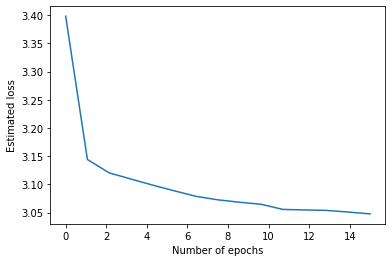

In [23]:
trainer.plot_running_loss()

In [7]:
_root_path = sys.path[0]
path = f'{_root_path}/train'
test_path = f'{_root_path}/test'
data_info_path = f'{_root_path}/train.csv'
labels_info_path = f'{_root_path}/labels.csv'
dataset = TrainValSet(train_val_split=False, path=path, 
                      data_info_path=data_info_path, labels_info_path=labels_info_path,
                      test_path=test_path)
tag='50'
weight_path = f'{_root_path}/pretrained/resnet{tag}.pth'
model = ArtCV(tag=tag, weight_path=weight_path, freeze_cnn=True, dropout_rate=0, weights=(1, 1, 2, 1, 1), classifier_layers=(2, 2, 1, 2, 2))

trainer = Trainer(model, dataset, batch_size_train=512, batch_size_val=512, batch_size_all=32,
                  batch_size_test=64,
                  epochs=15, compute_acc=False,
                  monitor_frequency=3,
                  dataloader_train_kwargs={'num_workers':2}, dataloader_val_kwargs={'num_workers':2},
                  dataloader_all_kwargs={'num_workers':2})

file_name = 'frozen_first3layers_resnet50_2layer_15epochs_reduced_lr.model.pkl'
save_path = f'{_root_path}/weights/{file_name}'
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
gt, probs = trainer.get_probs(tag='all')

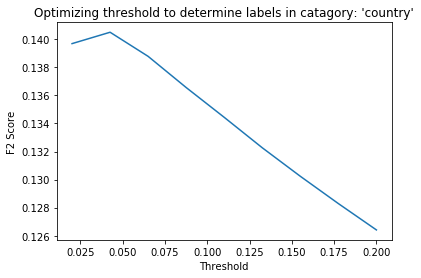

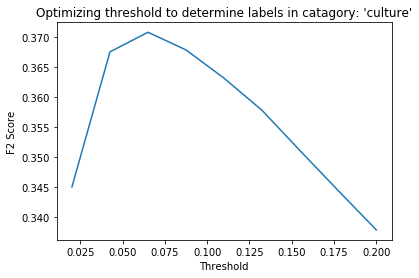

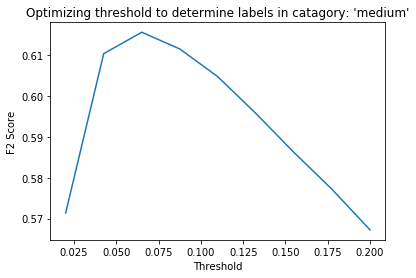

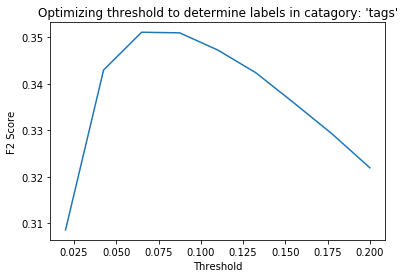

In [29]:
from sklearn.metrics import fbeta_score

def f2score_single_thre(ground_truth, probs, thre, return_mean=True):
    predictions = np.zeros(probs.shape, dtype='int')
    predictions[probs > thre] = 1
    f_beta = [fbeta_score(ground_truth[i,:], predictions[i,:], beta=2) for i in range(ground_truth.shape[0])]
    if return_mean:
        return sum(f_beta)/len(f_beta)
    else:
        return f_beta

boundary = ([0, 100], [100, 781], [786, 2706], [2706, 3474])
catagories = ('country', 'culture', 'medium', 'tags')
fb = dict()
for i, catagory in enumerate(catagories):
    fb[catagory]=[]
    for i_ in range(2, 20, 2):
        thre = 0.01*i_
        fb[catagory].append(f2score_single_thre(gt[:, boundary[i][0]: boundary[i][1]], probs[:, boundary[i][0]: boundary[i][1]], thre=thre))

    len_ticks = len(fb[catagory])
    x_axis = np.linspace(0.02, 0.2, len_ticks)
    plt.figure()

    plt.plot(x_axis, fb[catagory])
    plt.title("Optimizing threshold to determine labels in catagory: '%s'"
             %catagory)
    plt.xlabel('Threshold')
    plt.ylabel('F2 Score')
    plt.show()


In [30]:
def f2score(ground_truth, probs, thre, boundary=([0, 100], [100, 781], [786, 2706], [2706, 3474]), return_mean=True):
    if type(thre) == float:
        thre = (thre, thre, thre, thre)
    predictions = np.zeros(probs.shape, dtype='int')
    for i in range(len(boundary)):
        predictions[:, boundary[i][0]: boundary[i][1]][
            probs[:, boundary[i][0]: boundary[i][1]] > thre[i]] = 1
    f_beta = [fbeta_score(ground_truth[i,:], predictions[i,:], beta=2) for i in range(ground_truth.shape[0])]
    if return_mean:
        return sum(f_beta)/len(f_beta)
    else:
        return f_beta

f2score(gt, probs, thre=(0.04, 0.06, 0.06, 0.06))

0.5189223106200906

In [9]:
thre=(0.04, 0.06, 0.06, 0.06)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.5693199511624866

In [10]:
thre=(0.06, 0.06, 0.06, 0.06)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.5701082419552248

In [11]:
thre=(0.08, 0.08, 0.08, 0.08)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.5729043735269962

In [12]:
thre=(0.1, 0.1, 0.1, 0.1)
f2score(gt, regularized_pred(probs, thre=thre), return_mean=True)

0.5714427257164598

In [15]:
file_name_gt = 'frozen_resnet50_2layer_15epochs_reduced_lr_gt.npy'
save_path_gt = f'{_root_path}/weights/{file_name_gt}'
np.save(save_path_gt, gt)

In [16]:
file_name_probs = 'frozen_resnet50_2layer_15epochs_reduced_lr_probs.npy'
save_path_probs = f'{_root_path}/weights/{file_name_probs}'
np.save(save_path_probs, probs)

In [8]:
_root_path = sys.path[0]
path = f'{_root_path}/train'
test_path = f'{_root_path}/test'
data_info_path = f'{_root_path}/train.csv'
labels_info_path = f'{_root_path}/labels.csv'
dataset = TrainValSet(train_val_split=False, path=path, 
                      data_info_path=data_info_path, labels_info_path=labels_info_path,
                      test_path=test_path)
tag='50'
weight_path = f'{_root_path}/pretrained/resnet{tag}.pth'
model = ArtCV(tag=tag, weight_path=weight_path, freeze_cnn=True, dropout_rate=0, weights=(1, 1, 2, 1, 1), classifier_layers=(2, 2, 1, 2, 2))

trainer = Trainer(model, dataset, batch_size_train=512, batch_size_val=512, batch_size_all=256,
                  batch_size_test=256,
                  epochs=15, compute_acc=False,
                  monitor_frequency=3,
                  dataloader_train_kwargs={'num_workers':2}, dataloader_val_kwargs={'num_workers':2},
                  dataloader_all_kwargs={'num_workers':2})

file_name = 'frozen_resnet50_2layer_15epochs_reduced_lr.model.pkl'
save_path = f'{_root_path}/weights/{file_name}'
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>